In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import the files

Import the two files, starting with the users files. Let's create a column of boolean corresponding to either being an adopted user or not

In [315]:
users = pd.read_csv("takehome_users.csv",encoding = "ISO-8859-1")
users['adopted_user'] = np.nan
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,NaN
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN


We then import the logins file

In [12]:
userlogins = pd.read_csv("takehome_user_engagement.csv")
userlogins.head(10)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1


## Cleaning and generating the data

We create a table grouped by user_id and which ranks the logins chronologically. We then add a column corresponding to the logins in seconds (with respect to the absolute time)

In [51]:
# index = [tuple([df1.user_id[i], df1.index[i]]) for i in range(len(userlogins))]
# index = pd.MultiIndex.from_tuples(index, names=['user_id', 'old_index'])

In [323]:
df1 = userlogins.drop(['visited'], axis = 1)
df1.time_stamp = pd.to_datetime(df1.time_stamp)
df1 = df1.sort_values(['user_id','time_stamp'])

In [324]:
df2 = df1.groupby(by=['user_id','time_stamp']).count()
df2['time_seconds']=df2.index.get_level_values(1).strftime('%s').astype(int)

In [325]:
df2.head(15)

time_seconds
user_id time_stamp                       
1       2014-04-22 03:53:30    1398153210
2       2013-11-15 03:45:04    1384505104
        2013-11-29 03:45:04    1385714704
        2013-12-09 03:45:04    1386578704
        2013-12-25 03:45:04    1387961104
        2013-12-31 03:45:04    1388479504
        2014-01-08 03:45:04    1389170704
        2014-02-03 03:45:04    1391417104
        2014-02-08 03:45:04    1391849104
        2014-02-09 03:45:04    1391935504
        2014-02-13 03:45:04    1392281104
        2014-02-16 03:45:04    1392540304
        2014-03-09 03:45:04    1394351104
        2014-03-13 03:45:04    1394696704
        2014-03-31 03:45:04    1396251904

For each user, we count the number of logins. If that number is less than 3, automatically, the user isn't adopted. If the number is greater or equal than 3, we count the time difference between a login and the two consecutive ones. If both time differences are less than a week (in seconds), the user is adopted. By definition, an adopted user needs to satisfy this condition at least once

In [326]:
secondsperweek = 7*24*60*60

for i in range(len(users)+1):
    s = df2.query('user_id == '+ str(i))['time_seconds'].tolist()
    nlogins = len(s)
    if nlogins <= 2:
        users.loc[users.object_id == i,'adopted_user'] = False
    else:
        conds = [  ( (s[j+1] - s[j]) < secondsperweek ) & ( (s[j+2] - s[j]) < secondsperweek ) for j in range(nlogins-2) ]
        if sum(conds) >= 1:
            users.loc[users.object_id == i,'adopted_user'] = True
        else:
            users.loc[users.object_id == i,'adopted_user'] = False

In [327]:
users.adopted_user.value_counts(dropna = False, normalize = True)

False    0.866417
True     0.133583
Name: adopted_user, dtype: float64

Only about 13% of the users are adopted users

In [328]:
users.to_csv('takehome_adopted_users.csv')

## Analysis

Now that we have our dataframe, let's investigate which elements play a role in the user adoption status. We remove some of useless features like name and email

In [341]:
df = users.drop(['name','email'], axis = 1)
df = df.set_index('object_id')
df.creation_time = pd.to_datetime(df.creation_time)

In [363]:
df.head(7)

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,referred,was_referred
object_id,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False,True,True
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,True,True,True
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False,True,True
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False,True,True
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False,True,True
6,2013-12-17 03:37:06,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,False,True,True
7,2012-12-16 13:24:32,SIGNUP,1.356010e+09,0,1,37,NaN,False,False,False


In [352]:
dfca = pd.crosstab(df.creation_source,df.adopted_user)
dfca = dfca.div(dfca.sum(axis=1), axis=0)
dfca

adopted_user,False,True
creation_source,,
GUEST_INVITE,0.833564,0.166436
ORG_INVITE,0.870005,0.129995
PERSONAL_PROJECTS,0.922312,0.077688
SIGNUP,0.859607,0.140393
SIGNUP_GOOGLE_AUTH,0.831769,0.168231


In [362]:
dfbis = df
dfbis['was_referred'] = (dfbis.invited_by_user_id > 1)
dfra = pd.crosstab(dfbis.was_referred,dfbis.adopted_user)
dfra = dfra.div(dfra.sum(axis=1), axis=0)
dfra

adopted_user,False,True
was_referred,,
False,0.876411,0.123589
True,0.857722,0.142278


In [379]:
dfbis['referred'] = 0
for i in range(1, len(dfbis)+1):
    try:
        dfbis.loc[ int(dfbis.loc[i]['invited_by_user_id']) , 'referred'] += 1
    except:
        pass
    
dfrea = pd.crosstab(dfbis.referred,dfbis.adopted_user)
dfrea = dfrea.div(dfrea.sum(axis=1), axis=0)

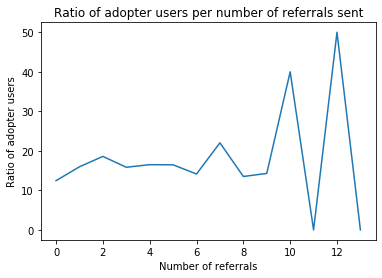

In [406]:
plt.plot(dfrea.index,dfrea[1]*100)
plt.xlabel("Number of referrals")
plt.ylabel("Ratio of adopter users")
plt.title("Ratio of adopter users per number of referrals sent")
plt.show()